# Soiling detection pipeline
For detection and visualisation of losses due to soiling of strings of panels at large scale solar power plants.
 
Modified from final project for Propulsion Academy Data Science immersive course, written by Lisa Crowther, Lina Siegrist and Marcus Lindberg <br>

Input data is:
- power production per string of panels: time series data
- environment (temperature and irradiance): time series data.

This code performs the following steps to detect soiling rates per string of panels:<br>
- Preprocessing: Calculation of efficency (energy production index: EPI) for each string of panels per 5 minute timepoint, where environment data is not NA. 
- Time-of-day filter: Remove timepoints introducing variation due to time-of-day (eg irradiance insufficiency) 
- Big-drop filter: Filters out drops in EPI that are likely due to faults, not soiling losses
- Bad day filter: Filters out changes in EPI likely due to bad weather days, not soiling losses 
- Soiling detection <br>

CSVs are saved of the dataframes generated at each step

## 1. Preprocessing:

- calculate theoretical maximum power output per string (5 minute timepoints)
- calculate energy performance index (EPI) for each string (5 minute timepoints)


In [80]:
import pandas as pd
import numpy as np
import matplotlib
import copy
import matplotlib.pyplot as plt
from pathlib import Path

import datetime
from datetime import datetime
import warnings

In [81]:
root_path = "../data/raw/"
working_dir = "../data/temp/"

power_filepath = root_path + "string_production.csv"
environment_filepath = root_path + "environmental.csv"
capacity_filepath = root_path + "capacity.csv"


In [82]:

def save_data(dataframes, names, root_dir, sub_dir):

    if root_dir[-1] != "/":
                root_dir += "/"

    if sub_dir[-1] != "/":
                root_dir += sub_dir + "/"

    for data, name in zip(dataframes, names):
        try:
            filepath_out = root_dir + name + ".csv"
            Path(root_dir).mkdir(parents=True, exist_ok=True)
            print(f"\tSaving {filepath_out}...")
            data.to_csv(filepath_out)
            print("\tDone.")
        except Exception as e:
            print(e)
            pass

In [83]:
## df_pow df: power output of each string every 5 minutes, index is date-time
## df_env df: temperature and irradiance every 5 minutes ('Temp_A','Temp_P', 'Irradiance'), index is date-time
## df_cap: capacity of each string ('capacity_kW'), index is stringname

df_pow = pd.read_csv(power_filepath, delimiter=',',parse_dates=['datetime'], date_parser = pd.to_datetime, index_col='datetime')
df_env = pd.read_csv(environment_filepath, delimiter = ',',parse_dates=['datetime'], date_parser = pd.to_datetime, index_col='datetime')
df_cap = pd.read_csv(capacity_filepath, index_col=0)

In [84]:
df_env.columns=['Temp_A','Temp_P','Irradiance']

In [85]:
# Determine capacity per string if not supplied: from total panel area and efficiency per string
#cap= (totalPanelA*Efficiency)

In [86]:
# Use only timepoints with env data 
df_env_sub = df_env.dropna()

In [87]:
## Merge power and environment data, only timepoints without nas in environment data:
power_env = pd.merge(df_pow,df_env_sub, on=['datetime'], how='inner')

In [267]:
## Dataframe with output data per string, only for timepoints without nas in environment data:
output_sub= power_env.drop(columns=['Temp_A','Temp_P', 'Irradiance'])

### Calculate theoretical outputs (maxP) per 5 min timepoint
- Calcuate temperature and irradiance adjustment of theoretical maximum power output capacity of each string: <br>
maxP = capacity * (Irradiance/1000 * (1+((Temp_P-To) * gamma)))

In [268]:
# Calculate irradiance and temperature adjustment
To = 25
gamma = -0.004

df_env_sub['irr_T_adj'] = df_env_sub.Irradiance/1000 * (1+((df_env_sub.Temp_P-To) * gamma))
factor_Irr_Temp = df_env_sub.drop(columns=['Temp_A','Temp_P','Irradiance'])

In [269]:

cap = df_cap['capacity_kW']



In [270]:

#multiply the capacity for each string by the irradiance and temperature adjustment factor
#use only timepoints with irradiance data

for i in range(len(cap)):

    factor_Irr_Temp[cap.index[i]]=factor_Irr_Temp.irr_T_adj*cap[i]
    
## Drop the adjustment factor column after calculating theoretical power output per string per 5 min timepoint

maxP_df = copy.deepcopy(factor_Irr_Temp.drop(columns=['irr_T_adj']))

In [271]:
output_sub.columns=maxP_df.columns

### Calculate Energy Performance Index (EPI) per 5 min timepoint
Power output/ theoretical calculated output

In [272]:
EPI= output_sub.div(maxP_df)

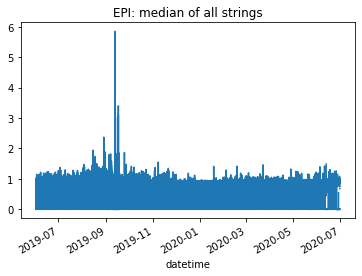

In [273]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    EPI.median(axis=1).plot(title='EPI: median of all strings')

Save csvs: 
Output data of strings/CBs only, EPIs of strings/CBs, theoretical output of strings/CBs


In [275]:

save_data([output_sub, EPI, maxP_df], ["df_output", "df_EPI", 'df_theor_output'], working_dir, "preprocessing")

	Saving ../data/temp/preprocessing/df_output.csv...
	Done.
	Saving ../data/temp/preprocessing/df_EPI.csv...
	Done.
	Saving ../data/temp/preprocessing/df_theor_output.csv...
	Done.


## 2.Time-of-day filter


- visualise median EPI of all strings over the day, grouped by month
- visualise EPI variation across the whole day, with varying start and end times
- plot EPI (median of all strings) over a chosen time window, median of all strings for all days
- plot EPI (median of all strings) over a chosen time window, for the first day of each month
- apply time mask with chosen times of day and plot hourly-aggregated EPI with and without the time filter

In [ ]:

working_dir = "../data/temp/"

In [150]:
root_path = "../data/temp/preprocessing/"

output_filepath = root_path + "df_output.csv"
EPI_filepath = root_path + "df_EPI.csv"
theor_output_filepath = root_path + "df_theor_output.csv"

In [197]:
output=pd.read_csv(output_filepath, delimiter=',',parse_dates=['datetime'], date_parser = pd.to_datetime, index_col='datetime')
EPI_df=pd.read_csv(EPI_filepath, delimiter = ',',parse_dates=['datetime'], date_parser = pd.to_datetime, index_col='datetime')
theor_output = pd.read_csv(theor_output_filepath, delimiter=',',parse_dates=['datetime'], date_parser = pd.to_datetime, index_col='datetime')


### Time-of-day variation analysis

#### Visualise median EPI of all strings over the day grouped by month

In [198]:
EPI_plot= copy.deepcopy(EPI_df)
EPI_plot['TimeOfDay']=EPI_plot.index
EPI_plot['MonthOfYear']=EPI_plot['TimeOfDay'].apply(lambda x: datetime.strftime(datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S'), '%Y-%m'))
EPI_plot['TimeOfDay']=EPI_plot['TimeOfDay'].apply(lambda x: datetime.strftime(datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S'), '%H:%M:%S'))

In [199]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    EPI_plot['med_strings']= EPI_plot.median(axis=1)


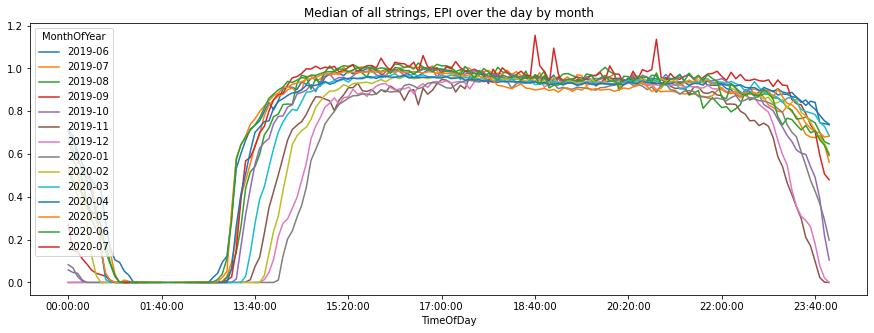

In [200]:
EPI_plot= EPI_plot.groupby(['TimeOfDay','MonthOfYear']).mean().unstack()

EPI_plot.med_strings.plot(figsize=(15,5))
plt.title('Median of all strings, EPI over the day by month');

#### Visualise EPI variation across the whole day, with varying start and end times

First set end time as 23:55 and find std of whole day with each hour for start time

In [201]:

def get_sdv_mean_range(df, starttimes, endtime):
    dfnew = pd.DataFrame()
    for start in starttimes:
        df_selected = df.between_time(start, endtime)
        df_resample=df_selected.resample('d')
        df_day_mean=df_resample.mean()
        df_day_std=df_resample.std()
        sdv_mean= df_day_std.mean().mean()
        df_temp=pd.DataFrame({'start':start, 'end':endtime, 'sdv_mean':[sdv_mean]})
        dfnew= pd.concat([dfnew, df_temp], ignore_index=True)
    dfnew.set_index('start', drop=True, inplace=True)
    return dfnew

In [202]:

EPI= copy.deepcopy(EPI_df)
EPI.index= pd.to_datetime(EPI.index, format='%Y-%m-%d %H:%M:%S')
alltimes=EPI.index.strftime("%H:%M").unique()
starttimes=alltimes
endtime = '23:55'

In [203]:
sdv_starttimes= get_sdv_mean_range(EPI, starttimes,endtime)

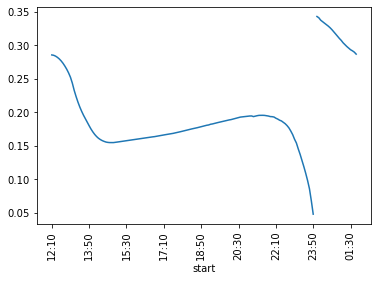

In [204]:
sdv_starttimes.sdv_mean.plot()
plt.xticks(rotation='vertical');

Then choose the start time according to best from above and visuaise the std with varying end times

In [205]:
def get_sdv_mean_range_end(df, starttime, endtimes):
    dfnew = pd.DataFrame()
    for end in endtimes:
        df_selected = df.between_time(starttime, end)
        df_resample=df_selected.resample('d')
        df_day_mean=df_resample.mean()
        df_day_std=df_resample.std()
        sdv_mean= df_day_std.mean().mean()
        df_temp=pd.DataFrame({'start':starttime, 'end':end, 'sdv_mean':[sdv_mean]})
        dfnew= pd.concat([dfnew, df_temp], ignore_index=True)
    dfnew.index=dfnew.end
    return dfnew

In [206]:
endtimes= alltimes
starttime = endtimes[alltimes.to_list().index('15:30')]
starttime

'15:30'

In [207]:

sdv_endtimes =get_sdv_mean_range_end(EPI, starttime, endtimes)

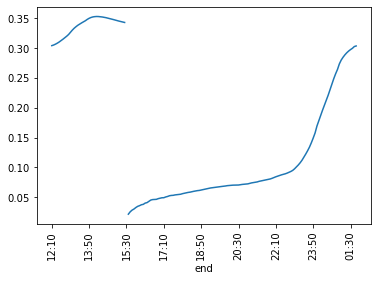

In [208]:
sdv_endtimes.sdv_mean.plot()
plt.xticks(rotation='vertical');

Choose end time from lowest point before variation starts rising again, minus 2h 

#### Plot EPI (median of all strings) over a chosen time window, for the first day of each month

In [209]:
def plot_EPI(df, year, month,day, starttime, endtime, col):
    df_selected = df[(df.index.year == year)&(df.index.month == month) & (df.index.day == day)].between_time(starttime, endtime)
    plt.plot(df_selected.index, df_selected[col])
    plt.xticks(rotation='vertical')
    plt.title('EPI: median all strings',fontsize= '20')
    plt.ylabel('EPI', fontsize='16')
    plt.xticks(fontsize='10')
    plt.show()

In [210]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    EPI['med_strings']=EPI.median(axis=1)

Plot first day of each month in 2020

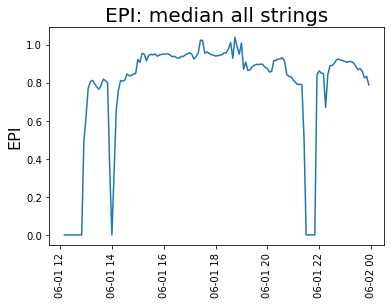

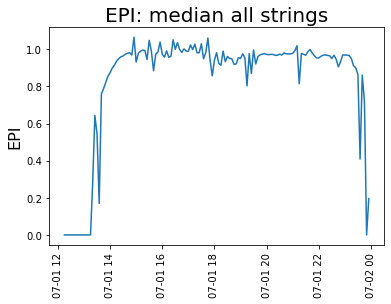

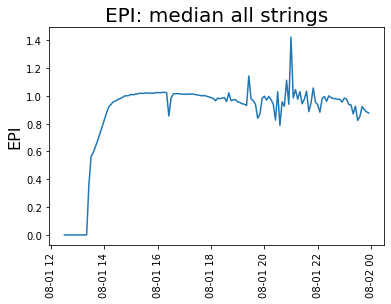

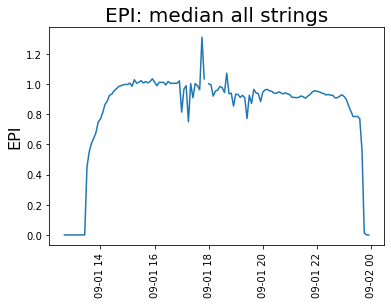

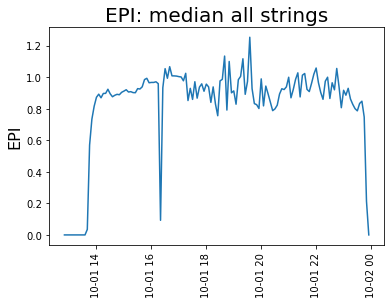

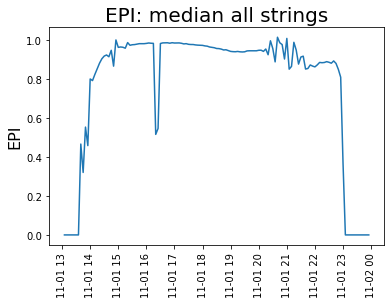

In [211]:
for month in range(6,12):
    plot_EPI(EPI, 2019,month,1,'09:00','23:55','med_strings')

#### Plot EPI over a chosen time window, median of all strings for all days

In [276]:
EPI['H']=EPI.index
EPI['H']= EPI['H'].apply(lambda x: datetime.strftime(datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S'), '%H'))


EPI_H =EPI.groupby('H').agg('median')
EPI_H['med_strings'].plot()

KeyError: 'med_strings'

#### Apply time mask with chosen times of day (most stable from above plots)

In [ ]:
#takes df with 'H' column as above
def time_mask(df, start, end):
    df1=copy.deepcopy(df)
    #new.set_index('byH', drop=True, inplace=True)
    new =df[(df1.H>start)&(df1.H< end)]
    new.drop(columns='H', inplace=True)
    return new

In [ ]:
time_masked_EPI = time_mask(EPI, '15', '19')

In [ ]:
time_masked_EPI.drop(columns=['med_strings'],inplace=True)

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    time_masked_EPI['med_strings']=time_masked_EPI.median(axis=1)

#### Plot median EPI of all strings for entire time period (hourly aggregated) with and without time mask

In [ ]:
time_masked_EPI.drop(columns=['med_strings'], inplace=True)

In [218]:
EPI.drop(columns=['med_strings','H'], inplace=True)


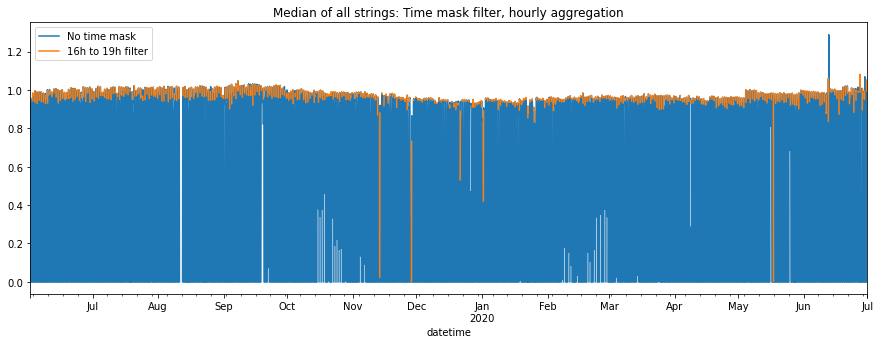

In [219]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    EPI.resample(rule='H').median().median(axis=1).plot(label='No time mask')
    time_masked_EPI.resample(rule='H').median().median(axis=1).plot(label='16h to 19h filter', figsize=(15,5))
plt.title('Median of all strings: Time mask filter, hourly aggregation')
plt.legend();

In [220]:

save_data([time_masked_EPI], ["EPI_timemask"], working_dir, "time_mask_filter")

	Saving ../data/temp/time_mask_filter/EPI_timemask.csv...
	Done.


In [221]:
EPI_timemask = copy.deepcopy(time_masked_EPI)

## 3. Big-drop filter


## Filter out days with large daily change in EPI (string-wise)


### Aggregate EPI by day and calculate the daily change 

In [222]:
EPI_timemask_D= EPI_timemask.resample(rule='D').mean()

In [223]:
lagdf_D = pd.DataFrame(copy.deepcopy(EPI_timemask_D))
for cols in lagdf_D.columns:
    lagdf_D[cols]=lagdf_D[cols]- lagdf_D[cols].shift(1)
    


In [224]:
leaddf_D = pd.DataFrame(copy.deepcopy(lagdf_D))
for cols in leaddf_D.columns:
    leaddf_D[cols]= leaddf_D[cols]-leaddf_D[cols].shift(-1)


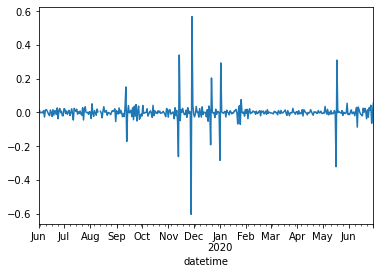

In [225]:
#Plot the median of all strings daily change in EPI
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    lagdf_D.median(axis=1).plot()

### Set thresholds for large drops/jumps
-1 std of the daily change in EPI

In [226]:
description_dailyagg = lagdf_D.describe()
mean_lag= description_dailyagg.loc['mean'].mean()
std_lag= description_dailyagg.loc['std'].mean()

lower_thresh_lag = mean_lag-std_lag
upper_thresh_lag = -lower_thresh_lag
lower_thresh_lag

-0.07227790619183502

In [227]:
description_dailyagg = leaddf_D.describe()
mean_lead= description_dailyagg.loc['mean'].mean()
std_lead= description_dailyagg.loc['std'].mean()

lower_thresh_lead = mean_lag-std_lag
upper_thresh_lead = -lower_thresh_lag
lower_thresh_lead

-0.07227790619183502

###  Create boolean masks for removing big drops/jumps
Also generates a mask for only removing big drops (drop_mask), if wanted

In [228]:

bool_1=lagdf_D.lt(lower_thresh_lag)
bool_2 =lagdf_D.gt(upper_thresh_lag)

bool_3=leaddf_D.lt(lower_thresh_lead)
bool_4 =leaddf_D.gt(upper_thresh_lead)


#if only using the drop filter
drop_mask=bool_1|bool_2
#if use the drop and jump filter: stringmask2
drop_jump_mask=bool_1|bool_2|bool_3|bool_4



In [229]:

EPI_bigdrop_filt = EPI_timemask_D.mask(drop_jump_mask)

#### Plot hourly-aggregated EPI with and without the time filter

### Save big-drop filtered EPIs, and the masks for filtering

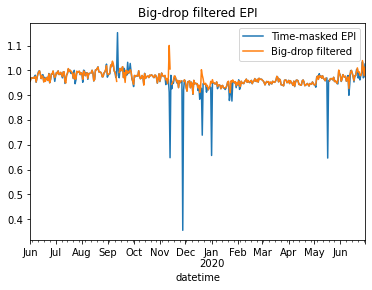

In [230]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    EPI_timemask_D.median(axis=1).plot(title='Big-drop filtered EPI', label='Time-masked EPI')
    EPI_bigdrop_filt.median(axis=1).plot(label='Big-drop filtered')
    plt.legend();


In [231]:

save_data([EPI_bigdrop_filt,drop_jump_mask,drop_mask], ["EPI_bigdrop_filt",'drop_jump_mask','drop_mask'], working_dir, "big_drop_filter")

	Saving ../data/temp/big_drop_filter/EPI_bigdrop_filt.csv...
	Done.
	Saving ../data/temp/big_drop_filter/drop_jump_mask.csv...
	Done.
	Saving ../data/temp/big_drop_filter/drop_mask.csv...
	Done.


## 4. Bad-day filter


In [232]:
root_path = "../data/temp/big_drop_filter/"
EPI_bigdrop_filt_filepath = root_path + "EPI_bigdrop_filt.csv"

In [233]:
EPI_bigdrop_filt = pd.read_csv(EPI_bigdrop_filt_filepath, delimiter=',',parse_dates=['datetime'], date_parser = pd.to_datetime, index_col='datetime')

#### Functions

In [234]:
def bad_day_filter_plot(df, threshold=1): # freqency of df: day
 
    # calculate mean & std of df_string_mean
    anal = pd.Series(df.values.ravel()).describe()
    mean = anal[1]
    std = anal[2]

    # plot histogram of df_string_mean
    ax = df.plot.hist(legend=False,color='orange',alpha=0.1)
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=2)
    plt.axvline(mean - (threshold * std), color='b', linestyle='dashed', linewidth=2)
    plt.axvline(mean + (threshold * std), color='b', linestyle='dashed', linewidth=2)
    plt.figtext(0.1, -0.05, 'mean', horizontalalignment='left', color='r',fontsize=15);
    plt.figtext(0.1, -0.1, 'mean ± threshold * std', horizontalalignment='left', color='b',fontsize=15);
    ax.set_ylabel('Frequency',fontsize=20)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
#     ax.set_xticks(np.arange(0.3, 1.2, 0.2),minor=False)
    ax.set_title('Density plot of mean of each string',fontsize=20)
#     ax.set_xlim(0.25,1.2)

In [235]:
def bad_day_filter(df, threshold=1):
    '''
    parameter
    ----------
    threshold: value outside 'mean ± threshold * std' will be 'True'.
    '''
    
    anal = pd.Series(df.values.ravel()).describe()
    mean=anal[1]
    std=anal[2]
    
    bool_days_1 = df.lt(mean + (threshold * std))
    bool_days_2 = df.gt(mean - (threshold * std))
    bool_days = bool_days_1 & bool_days_2
    
    return ~bool_days


#### Apply bad-day filter on big-drop-filtered data 

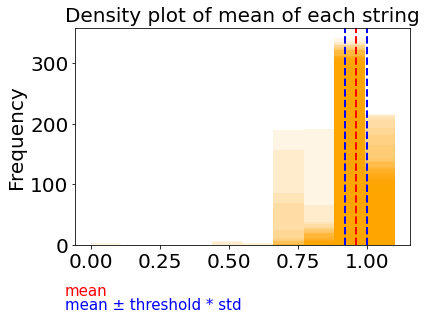

In [236]:
# decide the threshold (std) by plotting histogram: distribution of 'mean of string outputs' 
bad_day_filter_plot(EPI_bigdrop_filt, threshold = 1)

In [237]:
# get boolean for bad (True) and good (False) days
badday_mask = bad_day_filter(EPI_bigdrop_filt, threshold = 2)

In [238]:
# mask (substitute) data with NaN for bad days
EPI_dropsfilt_baddayfilt = EPI_bigdrop_filt.mask(badday_mask)

In [239]:
# Resulting DataFrame: big-drop & bad-day filtered (freq: day)
save_data([EPI_dropsfilt_baddayfilt, badday_mask], ["EPI_dropsfilt_baddayfilt","badday_mask"], working_dir, "bad_day_filter")

	Saving ../data/temp/bad_day_filter/EPI_dropsfilt_baddayfilt.csv...
	Done.
	Saving ../data/temp/bad_day_filter/badday_mask.csv...
	Done.


#### Plot <font color='red'>median</font> EPI of all strings per day with and without bad-day filter'

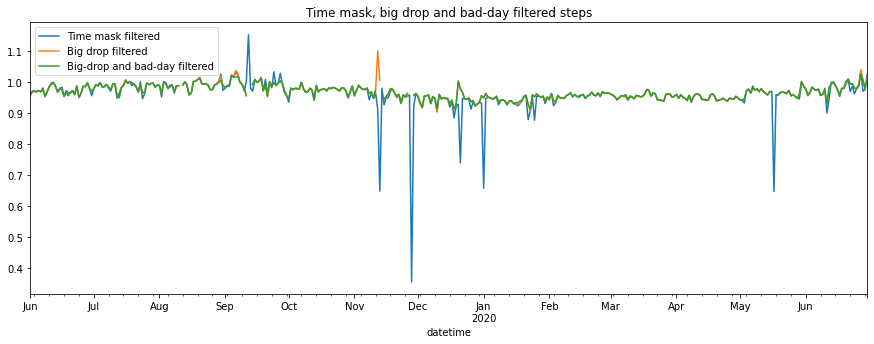

In [240]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    EPI_timemask_D.median(axis=1).plot(label='Time mask filtered')
    EPI_bigdrop_filt.median(axis=1).plot(label='Big drop filtered')
    EPI_dropsfilt_baddayfilt.median(axis=1).plot(title=('Time mask, big drop and bad-day filtered steps'), label='Big-drop and bad-day filtered', figsize=(15,5))
    plt.legend();

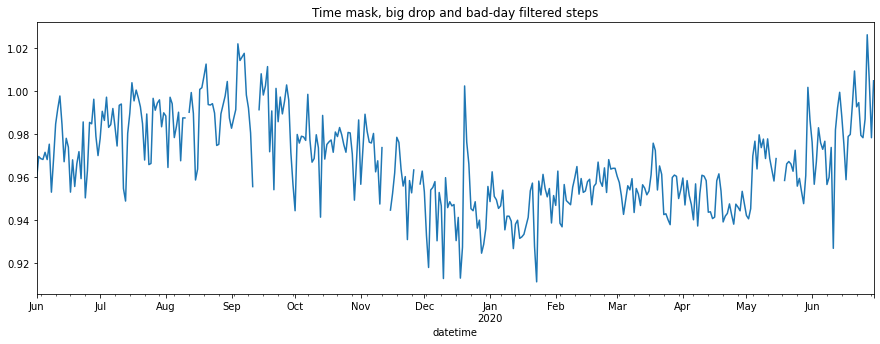

In [242]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    EPI_dropsfilt_baddayfilt.median(axis=1).plot(title=('Time mask, big drop and bad-day filtered steps'), label='Big-drop and bad-day filtered', figsize=(15,5))

# 4. Soiling detection and regression

#### Import EPI from previous steps: preprocessed, time masked, big-drop filtered and bad-day filtered

In [243]:
root_path = "../data/temp/bad_day_filter/"
EPI_dropsfilt_baddayfilt_filepath = root_path + "EPI_dropsfilt_baddayfilt.csv"

#### Import environmental data

In [244]:
root_path_2 = "../data/raw/"
env_data_filepath = root_path_2 + "environmental.csv"

In [245]:
df_env = pd.read_csv(env_data_filepath, delimiter=',',parse_dates=['datetime'], date_parser = pd.to_datetime, index_col='datetime')
df_env.columns = ['Temp_A', 'Temp_P', 'Irradiance']

In [246]:
# Calculate the daily irradiance, required for the soiling calculation using RdTools
daily_irr = df_env['Irradiance'].resample('D').sum()

In [247]:
# Dataframe and series of median EPI (daily aggregated)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    EPI_dropsfilt_baddayfilt['median_EPI'] = EPI_dropsfilt_baddayfilt.loc[:,:].median(axis=1)
    EPI_dropsfilt_baddayfilt_daily_median = EPI_dropsfilt_baddayfilt[['median_EPI']]
    EPI_dropsfilt_baddayfilt_daily_median_series = EPI_dropsfilt_baddayfilt_daily_median['median_EPI']
# Next line is: to avoid this error: ValueError: Daily performance metric series must have daily frequency
    EPI_dropsfilt_baddayfilt_daily_median_series = EPI_dropsfilt_baddayfilt_daily_median_series.resample('D').mean() 

## Perfome soiling calculation

In [248]:
import rdtools
from rdtools.soiling import soiling_srr
cl = 68.2
# whole data
sr, sr_ci, soiling_info = soiling_srr(EPI_dropsfilt_baddayfilt_daily_median_series, daily_irr, confidence_level=cl, day_scale=26, max_relative_slope_error=100.0)

/Users/lisacrowther/opt/anaconda3/envs/MLG/lib/python3.6/site-packages/rdtools/soiling.py:15: UserWarning: The soiling module is currently experimental. The API, results, and default behaviors may change in future releases (including MINOR and PATCH releases) as the code matures.
  'The soiling module is currently experimental. The API, results, '


## Plot data and soiling regression

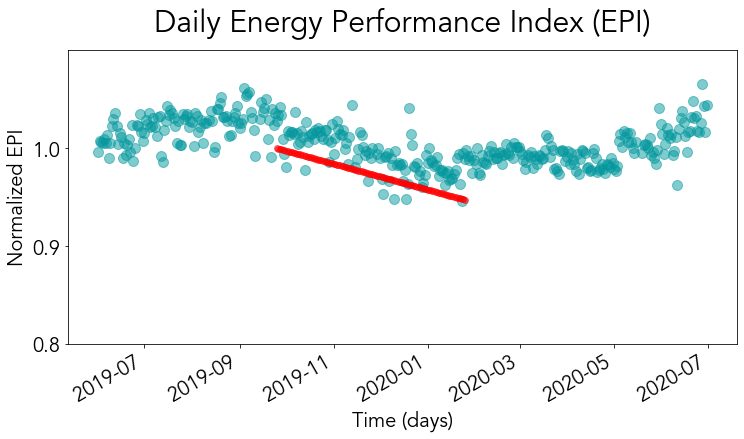

In [249]:

ymin=0.8
ymax=1.1

csfont = {'fontname':'Comic Sans MS'}
hfont = {'fontname':'Helvetica'}
afont = {'fontname':'Avenir'}

sratio = soiling_info['soiling_ratio_perfect_clean']
renormalized = EPI_dropsfilt_baddayfilt_daily_median_series / soiling_info['renormalizing_factor'] 

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(renormalized.index,renormalized,'o',alpha=0.5,markersize=10, color='#03989e')
ax.plot(sratio.index, sratio, 'o',color='r',alpha=0.5, label='Soiling ratio') 
ax.set_ylim(ymin, ymax)
ax.set_yticks(np.arange(ymin,1.05,0.1),minor=False)
ax.set_ylabel('Normalized EPI',fontsize=20, **afont)
ax.set_xlabel('Time (days)',fontsize=20, **afont)
plt.xticks(**afont)
plt.yticks(**afont)
ax.set_title('Daily Energy Performance Index (EPI)',pad = 20, fontsize=30, **afont)
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
fig.autofmt_xdate();
# fig.savefig('EPI.png');

## Calculate and plot soiling loss

In [250]:
daily_soiling_loss = 1 - EPI_dropsfilt_baddayfilt_daily_median_series

In [251]:
sratio = soiling_info['soiling_ratio_perfect_clean']

In [252]:
sloss = 1 - sratio

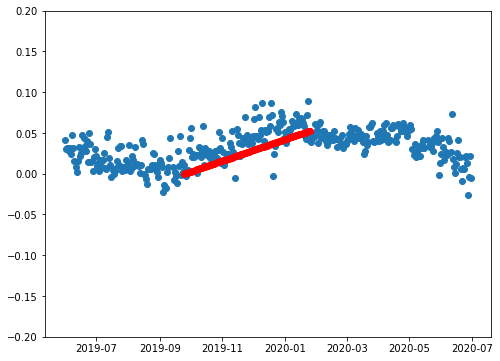

In [253]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(daily_soiling_loss.index, daily_soiling_loss,'o')
ax.plot(sloss.index, sloss, 'o', color='r')
ax.set_ylim(-0.2, 0.2);

## Soiling interval summary table

In [254]:
soiling_summary = soiling_info['soiling_interval_summary']


In [255]:
soiling_summary.to_csv("soiling_summary.csv")

## Calculate and view a monthly soiling rate summary

In [256]:
from rdtools.soiling import monthly_soiling_rates
monthly_soiling_summary = monthly_soiling_rates(soiling_info['soiling_interval_summary'], confidence_level=cl)


In [257]:
monthly_soiling_summary.to_csv("monthly_soiling_summary.csv")

## Generate a dataframe of soiling rate for each string

In [203]:
df_soiling = copy.deepcopy(EPI_dropsfilt_baddayfilt)
list = df_soiling.columns
df_soiling = df_soiling.drop(list, axis = 1)

In [ ]:
for name in EPI_dropsfilt_baddayfilt.keys():
    soiling = EPI_dropsfilt_baddayfilt[name]
    cl = 68.2
    sr, sr_ci, soiling_info = soiling_srr(soiling, daily_irr, confidence_level=cl, day_scale=20)
    df_soiling[name] = soiling_info['soiling_ratio_perfect_clean']

In [ ]:
# # export
df_soiling.to_csv('soiling_rate_per_string.csv')